# HW6
ENGN2912V

Seokkee Min

## P6

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import time

In [2]:
def wgan_gp_loss(real, fake, discrim, lambda_gp):
    r_disc_out = discrim(real)
    f_disc_out = discrim(fake)
    
    w_dist = torch.mean(r_disc_out) - torch.mean(f_disc_out)
    
    batch_size = real.size(0)
    alpha = torch.rand(batch_size, 1).expand_as(real)
    interpol = (alpha * real + (1 - alpha) * fake).requires_grad_(True)

    discrim_interpol = discrim(interpol)
    
    grads = torch.autograd.grad(outputs=discrim_interpol,
                                    inputs=interpol,
                                    grad_outputs=torch.ones_like(discrim_interpol),
                                    create_graph=True, 
                                    retain_graph=True)[0]
    penalty = ((grads.norm(2, dim=1) - 1)**2).mean()
    
    return - w_dist + lambda_gp * penalty

In [3]:
def create_wgan(input_dim, output_dim):
    gen = nn.Sequential(nn.Linear(input_dim, 8), 
                        nn.ReLU(), 
                        nn.Linear(8, 16), 
                        nn.ReLU(), 
                        nn.Linear(16, output_dim), 
                        nn.Tanh())

    discrim = nn.Sequential(nn.Linear(output_dim, 8), 
                            nn.LeakyReLU(), 
                            nn.Linear(8, 16), 
                            nn.LeakyReLU(), 
                            nn.Linear(16, 1))
    
    return gen, discrim

In [4]:
def trainWGAN(input_dim, output_dim, manual_break):
    gen, discrim = create_wgan(input_dim, output_dim)

    gen_optim = torch.optim.Adam(gen.parameters(), lr=0.001)
    d_optim = torch.optim.Adam(discrim.parameters(), lr=0.001)

    train_data = torch.Tensor(np.random.uniform(-1,1, (batch_size, output_dim)))

    test_data = np.random.uniform(-1, 1, (10000, output_dim))
    test_noise = np.random.normal(0, 1, (10000, input_dim))

    epoch = -1
    w_c = 0
    w_dists = []
    avg_epoch_time = 0
    
    m = f'Input Dim: {input_dim}, Output Dim: {output_dim}'
    print(m)
    print('-'*len(m))
    while w_c < 100:
        epoch_start_time = time.time()
        epoch += 1

        gen.train()
        discrim.train()

        # Noise using normal distribution
        noise = torch.Tensor(np.random.normal(0,1, (batch_size, input_dim)))
        # generate fake distribution
        fake_data = gen(noise)

        # check discrim performance
        d_optim.zero_grad()
        d_loss = wgan_gp_loss(train_data, fake_data, discrim, lambda_gp)
        d_loss.backward()
        d_optim.step()

        if epoch % 5 == 0:
            gen_optim.zero_grad()

            noise = torch.Tensor(np.random.normal(0,1, (batch_size, input_dim)))
            fake_data = gen(noise)
            fake_d_out = discrim(fake_data)

            gen_loss = -torch.mean(fake_d_out)
            gen_loss.backward()
            gen_optim.step()
        
        avg_epoch_time += time.time() - epoch_start_time
        
        if epoch % 100 == 0:
            gen.eval()
            with torch.no_grad():
                pred = gen(torch.Tensor(test_noise))

                w_dist = 0
                for i in range(output_dim):
                    w_dist += wasserstein_distance(test_data[:,i], pred.detach().numpy()[:,i])

            mean_wdist = w_dist/output_dim

            w_dists.append(mean_wdist)

            if mean_wdist < 0.05:
                w_c += 1

        if epoch % 10000 == 0:
            print(f'Epoch: {epoch} | Gen Loss: {gen_loss.item()} | Disc Loss: {d_loss.item()}\
| mean W: {(w_dists[-1]*100).round(1)}% | W count: {w_c}')
            
        if epoch >= manual_break:
            print('end')
            break

    print(f'\nFinished. Epoch: {epoch}, Wasserstein Dist Minima: {min(w_dists)}\n\n')
    
    return gen, discrim, w_dists, avg_epoch_time/epoch

In [5]:
output_dim = 5

lambda_gp = 10
num_epoch = 80000
batch_size = 500

torch.manual_seed(2)

test_data = np.random.uniform(-1, 1, (1000, output_dim))

input_dims = [2, 5, 10, 20]

preds = np.zeros((len(input_dims), test_data.shape[0], 2))
w_dists = []
avg_epoch_times = np.zeros(len(input_dims))

# Train
for i, input_dim in enumerate(input_dims):
    test_noise = np.random.normal(0, 1, (1000, input_dim))

    gen, discrim, w_dist, avg_epoch_time = trainWGAN(input_dim, output_dim, num_epoch)

    with torch.no_grad():
        pred = gen(torch.Tensor(test_noise)).detach().numpy()

    preds[i] = pred[:, 0:2]
    w_dists.append(w_dist)
    avg_epoch_times[i] = avg_epoch_time

Input Dim: 2, Output Dim: 5
---------------------------
Epoch: 0 | Gen Loss: -0.20849460363388062 | Disc Loss: 9.046486854553223| mean W: 48.5% | W count: 0
Epoch: 10000 | Gen Loss: 0.7329110503196716 | Disc Loss: -0.24434399604797363| mean W: 17.8% | W count: 0
Epoch: 20000 | Gen Loss: -0.3847768008708954 | Disc Loss: -0.04711082577705383| mean W: 7.8% | W count: 0
Epoch: 30000 | Gen Loss: 1.805145502090454 | Disc Loss: -0.17009717226028442| mean W: 10.2% | W count: 0
Epoch: 40000 | Gen Loss: 4.397182941436768 | Disc Loss: 0.014608893543481827| mean W: 9.5% | W count: 0
Epoch: 50000 | Gen Loss: -3.178504467010498 | Disc Loss: -0.13803383708000183| mean W: 12.5% | W count: 0
Epoch: 60000 | Gen Loss: -4.587452411651611 | Disc Loss: -0.06466581672430038| mean W: 8.3% | W count: 0
Epoch: 70000 | Gen Loss: 0.11126385629177094 | Disc Loss: -0.11662614345550537| mean W: 7.6% | W count: 0
Epoch: 80000 | Gen Loss: -2.166898012161255 | Disc Loss: -0.1873137503862381| mean W: 9.9% | W count: 0
e

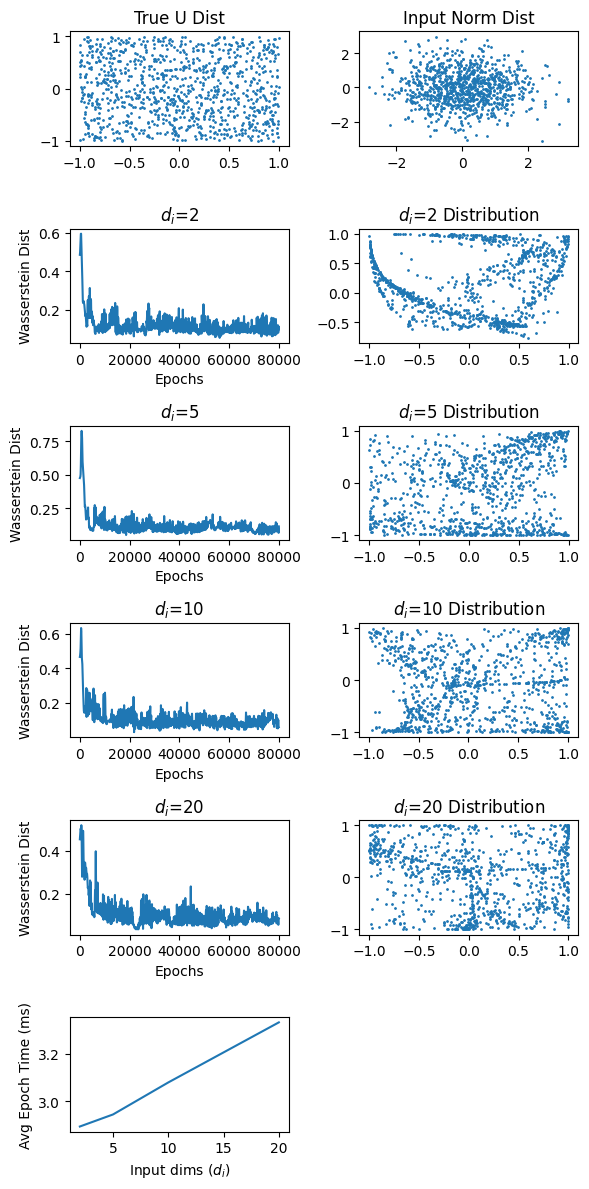

In [6]:
fig, axs = plt.subplots(2+len(w_dists), 2, figsize=(6, 3*len(w_dists)))
axs[0,0].scatter(test_data[:,0], test_data[:,1], s=1)
axs[0,0].set_title('True U Dist')
axs[0,1].scatter(test_noise[:,0], test_noise[:,1], s=1)
axs[0,1].set_title('Input Norm Dist')

for i in range(len(w_dists)):
    axs[i+1,1].scatter(preds[i, :, 0], preds[i, :, 1], s=1)
    axs[i+1,1].set_title(f'$d_i$={input_dims[i]} Distribution')
    
    axs[i+1,0].plot(np.arange(len(w_dists[i]))*100, w_dists[i])
    axs[i+1,0].set_xlabel('Epochs')
    axs[i+1,0].set_ylabel('Wasserstein Dist')
    axs[i+1,0].set_title(f'$d_i$={input_dims[i]}')

axs[i+2, 0].plot(input_dims, avg_epoch_times*1000)
axs[i+2, 0].set_xlabel('Input dims ($d_i$)')
axs[i+2, 0].set_ylabel('Avg Epoch Time (ms)')
axs[i+2, 1].remove()
plt.tight_layout()
plt.show()

Used: distribution data with 1000 datapoints, adam optimizer. Checked every 100 epochs to see if Wasserstein distance fell below 5%  during 80000 epochs of training. Put a counter on successes.

Lower input dimensions had some trouble meeting the 5% criteria. Input dim = 2 was not able to meet the 5% error for all 80000 training epochs (although it comes very close, so for Problem 8, we'll say it reached it after 80k epochs). There are stronger artifacts for dim = 2 as well (and covers the space less uniformly).

Generally, the training is able to meet the 5% criteria more easily as the input dimensions increase (w_count goes up as input dim and epoch increase, and the first w_count is reached at earlier epochs). A lower Wasserstein distance minimum is able to be reached as well, as the input dims increase.

W_dist seems to settle close to the floor very quickly, after approx 10000 epochs, but then bounces up and down while generally trending downward at a very slow slope.

If more datapoints are used, variance should go down, which may lead to a faster converging (5% error) network

Average computational costs (time) per epoch go up as input dimension goes up, almost linearly.

## Problem 7

In [7]:
output_dim = 20

lambda_gp = 10
num_epoch = 80000
batch_size = 500

torch.manual_seed(2)

test_data = np.random.uniform(-1, 1, (1000, output_dim))

input_dims = [2, 10, 20, 30]

preds20 = np.zeros((len(input_dims), test_data.shape[0], 2))
w_dists20 = []
avg_epoch_times20 = np.zeros(len(input_dims))

# Train
for i, input_dim in enumerate(input_dims):
    test_noise = np.random.normal(0, 1, (1000, input_dim))

    gen, discrim, w_dist, avg_epoch_time = trainWGAN(input_dim, output_dim, num_epoch)

    with torch.no_grad():
        pred = gen(torch.Tensor(test_noise)).detach().numpy()

    preds20[i] = pred[:, 0:2]
    w_dists20.append(w_dist)
    avg_epoch_times20[i] = avg_epoch_time

Input Dim: 2, Output Dim: 20
----------------------------
Epoch: 0 | Gen Loss: 0.1933741420507431 | Disc Loss: 8.906843185424805| mean W: 48.3% | W count: 0
Epoch: 10000 | Gen Loss: -0.5853956341743469 | Disc Loss: -1.0489362478256226| mean W: 16.0% | W count: 0
Epoch: 20000 | Gen Loss: -1.1942646503448486 | Disc Loss: -0.5730236172676086| mean W: 39.5% | W count: 0
Epoch: 30000 | Gen Loss: -1.7961852550506592 | Disc Loss: -1.0266239643096924| mean W: 26.0% | W count: 0
Epoch: 40000 | Gen Loss: -2.0571858882904053 | Disc Loss: -0.6566638350486755| mean W: 13.9% | W count: 0
Epoch: 50000 | Gen Loss: -2.985755205154419 | Disc Loss: -0.6722036600112915| mean W: 11.7% | W count: 0
Epoch: 60000 | Gen Loss: -3.1093075275421143 | Disc Loss: -0.5514726042747498| mean W: 14.9% | W count: 0
Epoch: 70000 | Gen Loss: -0.5947152376174927 | Disc Loss: -0.4872663617134094| mean W: 11.8% | W count: 0
Epoch: 80000 | Gen Loss: -1.0372720956802368 | Disc Loss: -0.5702698230743408| mean W: 10.5% | W count

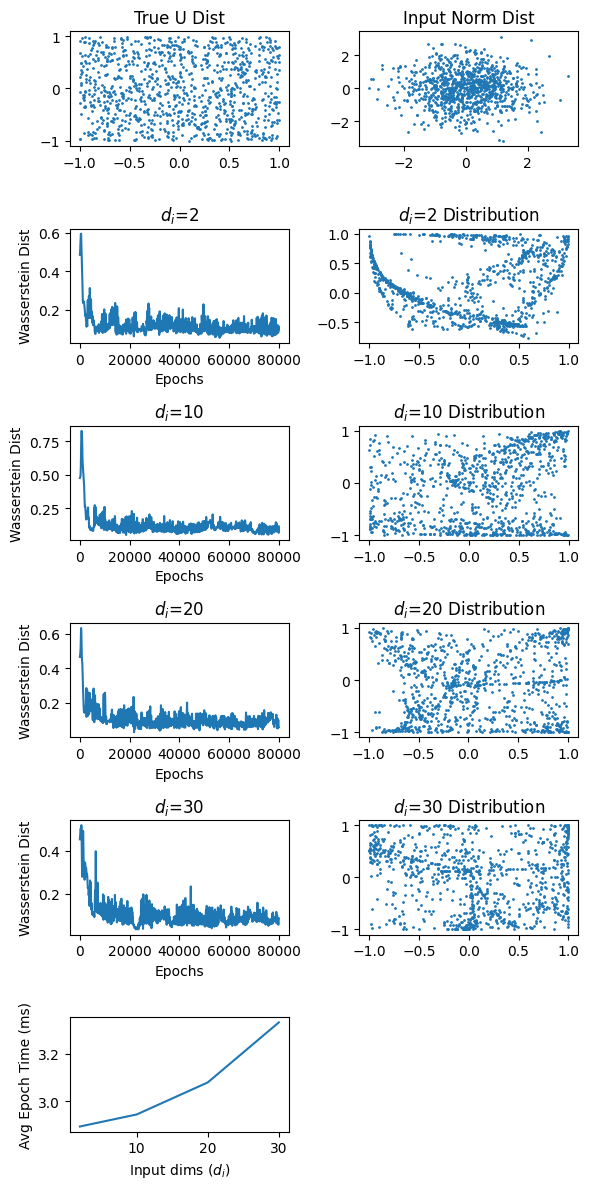

In [8]:
fig, axs = plt.subplots(2+len(w_dists), 2, figsize=(6, 3*len(w_dists)))
axs[0,0].scatter(test_data[:,0], test_data[:,1], s=1)
axs[0,0].set_title('True U Dist')
axs[0,1].scatter(test_noise[:,0], test_noise[:,1], s=1)
axs[0,1].set_title('Input Norm Dist')

for i in range(len(w_dists)):
    axs[i+1,1].scatter(preds[i, :, 0], preds[i, :, 1], s=1)
    axs[i+1,1].set_title(f'$d_i$={input_dims[i]} Distribution')
    
    axs[i+1,0].plot(np.arange(len(w_dists[i]))*100, w_dists[i])
    axs[i+1,0].set_xlabel('Epochs')
    axs[i+1,0].set_ylabel('Wasserstein Dist')
    axs[i+1,0].set_title(f'$d_i$={input_dims[i]}')

axs[i+2, 0].plot(input_dims, avg_epoch_times*1000)
axs[i+2, 0].set_xlabel('Input dims ($d_i$)')
axs[i+2, 0].set_ylabel('Avg Epoch Time (ms)')
axs[i+2, 1].remove()
plt.tight_layout()
plt.show()

Some similarities hold here for the 20 dim output case:

For lower input dimensions (especially less than the output dimension), the model is unable to meet 5% w_dist over 80k training epochs. However, generally the minimum w_dist reached does decrease as the input dimension increases.

For the increased output dimensions = 20, the neural network is unable to reduce the w_dist to 0.05, for the input dimensions of 2, 10, 20, and 30, within 80k epochs. However, we do get close (approx 6-7%).

The average epoch time increases as the input dimension increases. It appears to be an exponential (or some similar non-linear) increase. 

## Problem 8

In [37]:
first_w5 = np.zeros((2, 4))

# w_dist = np.zeros(np.shape(w_dists))
# w_dist20 = np.zeros(np.shape(w_dists_20))
w_dist = np.array(w_dists)
w_dist20 = np.array(w_dists20)
print(np.shape(w_dist))

(4, 801)


In [61]:
a = []
b = []
c = []

for i in range(4):
    a = [j for j,k in enumerate(w_dist[i,:]) if k <= 0.05]
    a = np.array(a)
    # print(len(a))
    if a.size > 0:
        first_w5[0,i] = a[0] * 100 * avg_epoch_times[i]
    else:
        first_w5[0,i] = num_epoch * avg_epoch_times[i]
        
    a = []

for i in range(4):
    b = [j for j,k in enumerate(w_dist20[i,:]) if k <= 0.05]
    b = np.array(b)
    if b.size > 0:
        first_w5[1,i] = b[0] * 100 * avg_epoch_times[i]
    else:
        first_w5[1,i] = num_epoch * avg_epoch_times[i]
        
    b = []
# for i in range(len(w_dists_20)):
#     if any(w_dist20[i] < 0.5):
#         first_w5[1,i] = np.argmax(w_dist20[i] <= 0.5)[-1]*100 * avg_epoch_times20[i]
#     else:
#         first_w5[1,i] = num_epoch * avg_epoch_times[i]
    
    # total_times[1,i] = np.arange(len(w_dists_20[i]))[-1]*100 * avg_epoch_times_20[i]

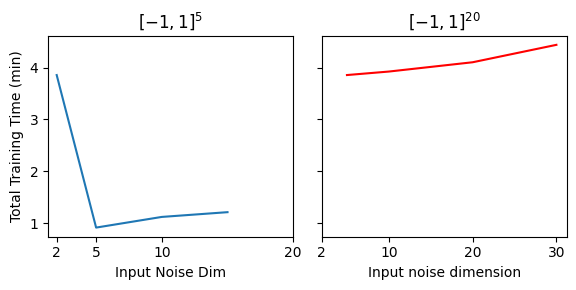

In [62]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6,3))

axs[0].plot([2, 5, 10, 15], first_w5[0, :]/60)
axs[0].set_title('$[-1,1]^5$')
axs[0].set_ylabel('Total Training Time (min)')
axs[0].set_xlabel('Input Noise Dim')
axs[0].set_xticks([2, 5, 10, 20])

axs[1].plot([5, 10, 20, 30], first_w5[1, :]/60, 'r')
axs[1].set_title('$[-1,1]^{20}$')
axs[1].set_xticks([2, 10, 20, 30])
axs[1].set_xlabel('Input noise dimension')

plt.tight_layout()

### Output dim = 5
For output dim = 5, the computational cost is high for input dim = 2, as it never was able to reach 5% wasserstein distance. For input dim = 5 and up, the computational time decreases significantly, which is to be expected since the 5% threshold is reached in fewer training epochs as input dimensions increase. However, the average epoch time does increase as input dimensions increase, so there is a small increase as the input dimension increases from 5. 

### Output dim = 20
For output dim = 20, the computational cost is much higher than output dim = 5. In the plot above, the "total training time" is artificially capped lower, as I was unable to reach the 5% threshold within 80k epochs. As such, the plot above demonstrates that computational cost is conservatively much higher as output dimension increases. There is also the trend of computational cost increasing as the input dimension increases.

If the WGAN ever converges for 5% threshold, for output dim = 20, and we continue in number of epochs much greater than required for convergence, we may see a similar computational cost behavior as output dim = 5.